<a href="https://colab.research.google.com/github/dbasso98/Unsupervised-Learning/blob/main/third_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Third Assignment - Unuspervised Learning course 
##  Individual household electric power consumption

The dataset used for this exercise is the following: https://archive-beta.ics.uci.edu/dataset/235/individual+household+

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/content/drive/MyDrive/UnsupervisedLearning')
from second_exercise.utils import normalize, PCA, plot_semilogy, get_explained_variance


In [ ]:
sns.reset_defaults()

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/UnsupervisedLearning/third_exercise/data/household_power_consumption.txt', sep=';')

<ipython-input-3-0ef3fe6b4470>:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/UnsupervisedLearning/third_exercise/data/household_power_consumption.txt', sep=';')


In [ ]:
# Data dimension
print(f'The original dimension of the dataset is: {data.shape}')

The original dimension of the dataset is: (2075259, 9)


#### Data Pre-treatement

Since the dataset is quite big we can reduce the number of entries by taking into account the average values per day for each of the measurements. Doing so, we get a new dataset with only Date as column and not Time.

In [ ]:
# Missing values and all the characters that are not numeric has to be substituted 
# by NaNs, doing so it is possible to individuate all the values that are missing in the dataset
data[['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3']] = data[['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3']].apply(pd.to_numeric, errors='coerce')
data['Date_time'] = pd.to_datetime(data['Date'] + data['Time'], format='%d/%m/%Y%H:%M:%S')
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S')

In [ ]:
# Let's first check if there are missing values in the dataset
data.isna().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Date_time                    0
dtype: int64

In [ ]:
# We can fill the missing values with the average values obtained in different 
# years, but considering the same month, day, hour and minute
data['grouped_datetime'] = data['Date_time'].dt.strftime('%m-%d-%H-%M')
average_values = data.groupby('grouped_datetime')['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'].transform('mean')
for column in ['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3']:
    data[column].fillna(average_values[column], inplace=True)

<ipython-input-7-8c559d571657>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_values = data.groupby('grouped_datetime')['Global_active_power', 'Global_reactive_power',


In [ ]:
# Let's check now if we have any missing value now
data.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Date_time                0
grouped_datetime         0
dtype: int64

In [ ]:
# We can remove the global intesity attribute (current metric, voltage)
# since we are interested in the active energy consumed
data = data.drop(data[['Global_intensity','Voltage']], axis=1)
# And convert all the metrics to the same unit (watt-hour)
data['Global_active_power'] = data['Global_active_power'].apply(lambda x: x*1000/60)
data['Global_reactive_power'] = data['Global_reactive_power'].apply(lambda x: x*1000/60)

In [ ]:
# As a final step, we take the average values per day
data = data.groupby("Date").mean().reset_index()

<ipython-input-10-de7f394bcf55>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby("Date").mean().reset_index()


In [ ]:
data.shape

(1442, 6)

### Dimensional reduction and clustering

2. Perform a cluster analysis with k-means or with a density-based clustering

In [ ]:
# We drop the date column since it is not a numerical value 
data_noDate = data.drop(["Date"], axis=1)

In [ ]:
data_noDate = data_noDate.to_numpy(dtype=np.float32)
data_normalized = normalize(data_noDate)

In [ ]:
# I decided to use DBSCAN as cluster algorithm.
# In this way, we won't have to decide a priori the number of clusters K
# and will be more robust with respect noise present in the dataset.
import random
from collections import defaultdict

def euclidian_distance(a, b):
    return np.linalg.norm(a-b)

def get_neighbors(X, epsilon, current_index):
    """ This function retains the current sample neighbors
        depending on the radius epsilon defined from DBSCAN
    """
    neighbors = []
    for i in range(X.shape[0]):
        if euclidian_distance(X[current_index], X[i]) < epsilon:
            neighbors.append(i)

    return neighbors

def expand(X, epsilon, min_points, clusters, point, current_neighbors, cluster_index):
    # Assign the current point to the cluster
    clusters[point] = cluster_index

    i = 0
    while i < len(current_neighbors):
        neighbor = current_neighbors[i]
        # If the neighbor was defined as a noise point
        # Include it in the cluster
        if clusters[neighbor] == -1:
            clusters[neighbor] = cluster_index

        # If the neighbor was still not processed
        # But was not a noise point, include it in the cluster and 
        # Continue the search
        elif clusters[neighbor] == 0:
            clusters[neighbor] = cluster_index
            new_neighbors = get_neighbors(X, epsilon, neighbor)

            # In the case this neighbor is another core point we just
            # extend the list of neighbors to process
            if len(new_neighbors) >= min_points:
                current_neighbors = np.concatenate((current_neighbors,new_neighbors))
            
        i+=1  

def DBSCAN(X, epsilon, min_points):
    # Initialize the process
    cluster_index = 0
    clusters = [0] * X.shape[0]
    
    for i in range(X.shape[0]):
        # If the point has already been assigned to a cluster, we skip it
        if clusters[i] != 0:
            continue
        
        # Otherwise, we retain its neighborhood
        current_neighbors = get_neighbors(X, epsilon, i)

        # If the point is a noise point
        if len(current_neighbors) < min_points:
            clusters[i] = -1

        # Otherwise it is either a core or a border point
        else:
            # Increase the cluster index
            cluster_index += 1
            # Expand the cluster
            expand(X, epsilon, min_points, clusters, i, current_neighbors, cluster_index)
    
    return clusters

In [ ]:
clusters = DBSCAN(data_normalized, 1, 10)

In [ ]:
# We can use PCA to visualize the clusters according to the first 2 components
eigenvalues, eigenvectors, Y = PCA(data_normalized, 2)

In [ ]:
get_explained_variance(eigenvalues)

array([0.67661583, 1.        ], dtype=float32)

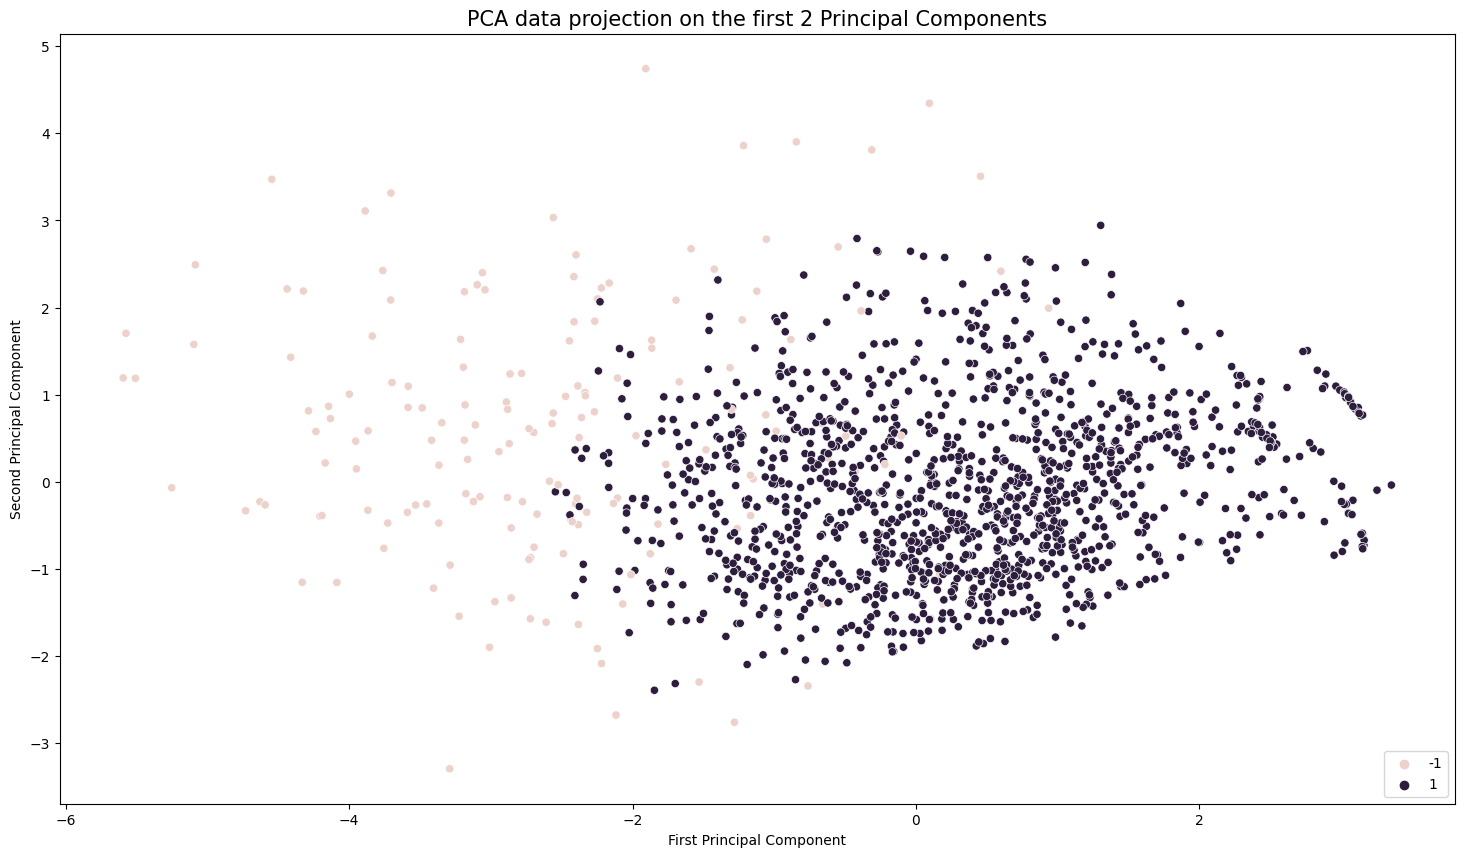

In [ ]:
plt.figure(figsize=(18,10))
sns.scatterplot(x = Y[:,0], y = Y[:,1], hue=clusters)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc='lower right',  bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.title('PCA data projection on the first 2 Principal Components', fontsize=15)
plt.show()

Anyway, since the next steps require the usage of K-means, I'll implement it too. (More precisely, the improved K-means++ algorithm).

In [ ]:
### K-means++

def squared_distance(x,y):
    return np.sum((x-y)**2, axis=-1)

def centroid_distance(points, centroids):
    """ Compute the distance between a point and a centroid

    Returns:
        Distance matrix D
    """
    return squared_distance(points[:,np.newaxis,:], centroids[np.newaxis,:,:])


def assign_point(distance_matrix):
    """ Assign a point to the same cluster of the nearest centroid

    Retruns:
        Assignation of points to one of the clusters 
    """
    return np.argsort(distance_matrix)[:,0]


def get_clusters(X, z):
    """ Divide the points into clusters

    Retruns:
        Clusters array
    """
    return [X[np.where(z==i), :].squeeze(0) for i in np.unique(z)]


def update_centroids(clusters):
    """ Update the centroids given the cluster assignations

    Returns:
        Centroids matrix C
    """
    return np.array([np.mean(cluster, axis=0) for cluster in clusters])


def objective_function(centroids, clusters):
    """ Compute the intra clusters sum of squares
    """
    return sum([squared_distance(clusters[i][:,np.newaxis,:],
                                centroids[np.newaxis,i,:]).sum() for i in range(len(centroids))])
    

def k_means_step(points, z):
    clusters = get_clusters(points, z)
    C = update_centroids(clusters)
    D = centroid_distance(points, C)
    z = assign_point(D)
    
    return C, D, z


def k_means_plusplus(X, k):
    #### K-means++ initialization
    # Pick a random point as first centroid
    random_index = np.random.randint(X.shape[0])
    C = np.array([X[random_index,:]])
    for _ in range(k-1):
        # Compute the distances from points to the centroids
        D = centroid_distance(X, C)

        # Take the minimum distance of every point from the centroids
        d = np.min(D, axis=1)

        # Compute the probability of a point of being the next centroid
        squared_d = np.square(d)
        probs = squared_d/np.sum(squared_d)

        # Pick a point based on the probabilites
        new_centroid_idx = np.random.choice(np.arange(len(X)), size=1, p=probs)

        # Add the point to the centroid matrix
        C = np.append(C, np.array([X[new_centroid_idx[0], :]]), axis=0)
    
    #### Usual K-means
    D = centroid_distance(X, C)
    z_prev = assign_point(D)
    C, D, z = k_means_step(X, z_prev)
    while (not np.array_equal(z_prev, z)):
        z_prev = z
        C, D, z = k_means_step(X, z_prev)
    objective = objective_function(C, get_clusters(X,z))

    return objective, z, C

In [ ]:
obj, z, C = k_means_plusplus(data_normalized, k=20)

K means is able to get better results in a smaller amount of time, so we will stick to it.

In order to pick the optimal value for K, we use the scree test, i.e. we take the loss function for multiple k values and check the elbow that is generated.

In [ ]:
def scree_plot(values, min_k, max_k, lag=1):
    """ Get the scree plot to retain the best K value for k-means
    """
    ticks = np.arange(min_k, max_k+1, lag)
    values = [value for i, value in enumerate(values) if i%lag == 0]
    plt.figure(figsize=(20,10))
    plt.scatter(np.arange(len(values)), values, marker='o', color='blue')
    plt.xticks(ticks=np.arange(len(ticks)), labels=ticks);
    plt.ylabel("Objective function value")
    plt.xlabel("Number of clusters k")
    plt.show()

In [ ]:
objectives = []
for k in range(2, 56):
    obj, _, _ = k_means_plusplus(data_normalized, k)
    objectives.append(obj)

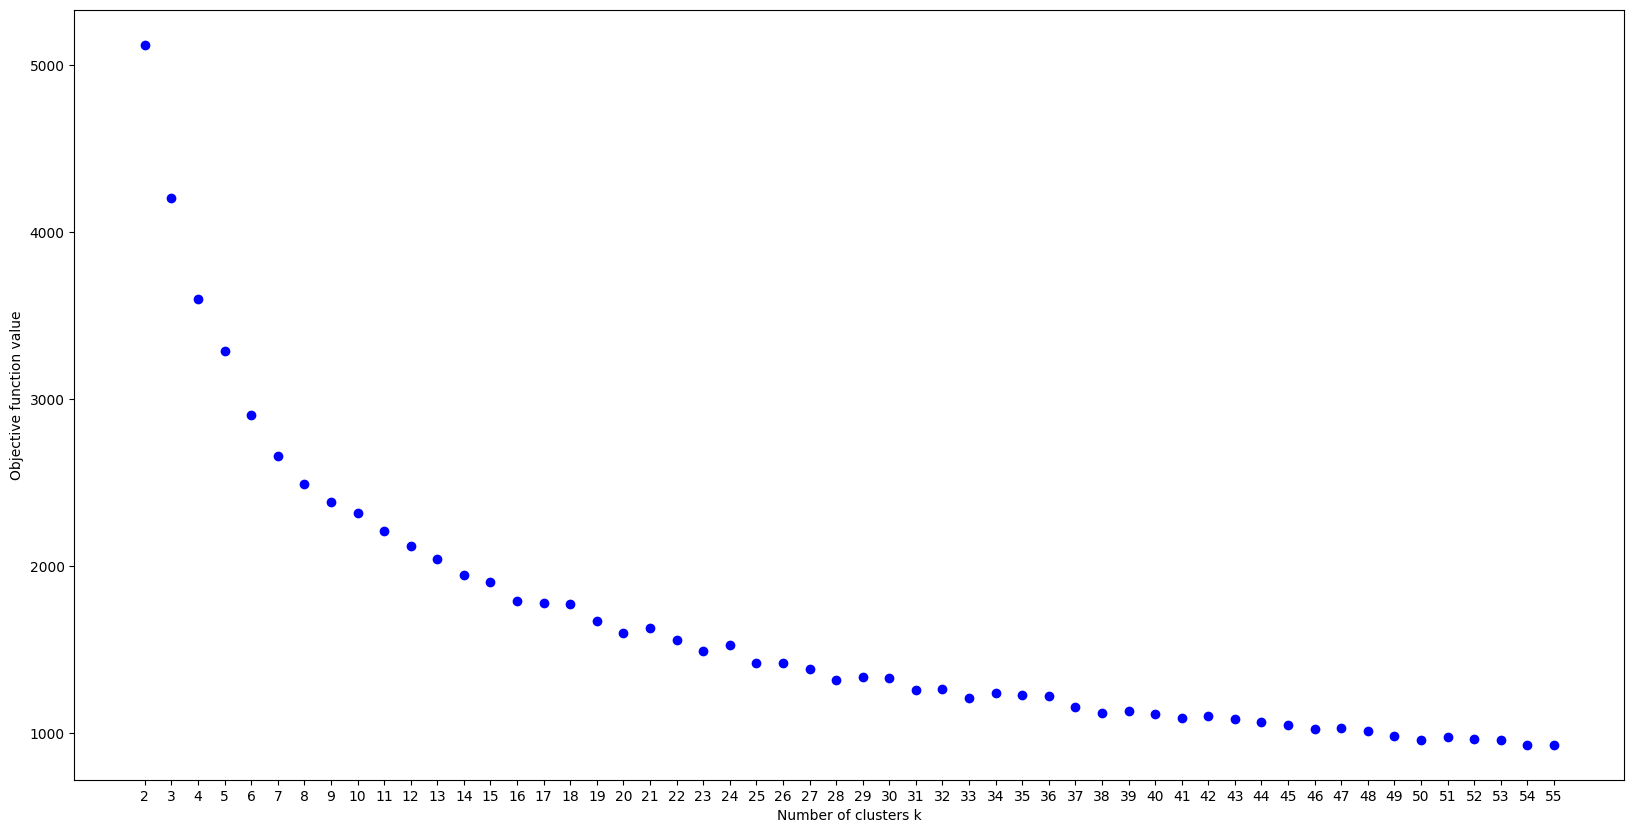

In [ ]:
scree_plot(objectives, 2, 55, 1)

In [ ]:
obj, z, C = k_means_plusplus(data_normalized, k=30)

3. Perform a dimensional reduction with a method of your choice, retaining only two coordinates, and visualize the clusters in the space of these
coordinates

We can project the clusters in the 2D space using PCA to reduce the dimensionality.

In [ ]:
# We can use PCA to visualize the clusters according to the first 2 components
eigenvalues, eigenvectors, Y = PCA(data_normalized, 2)

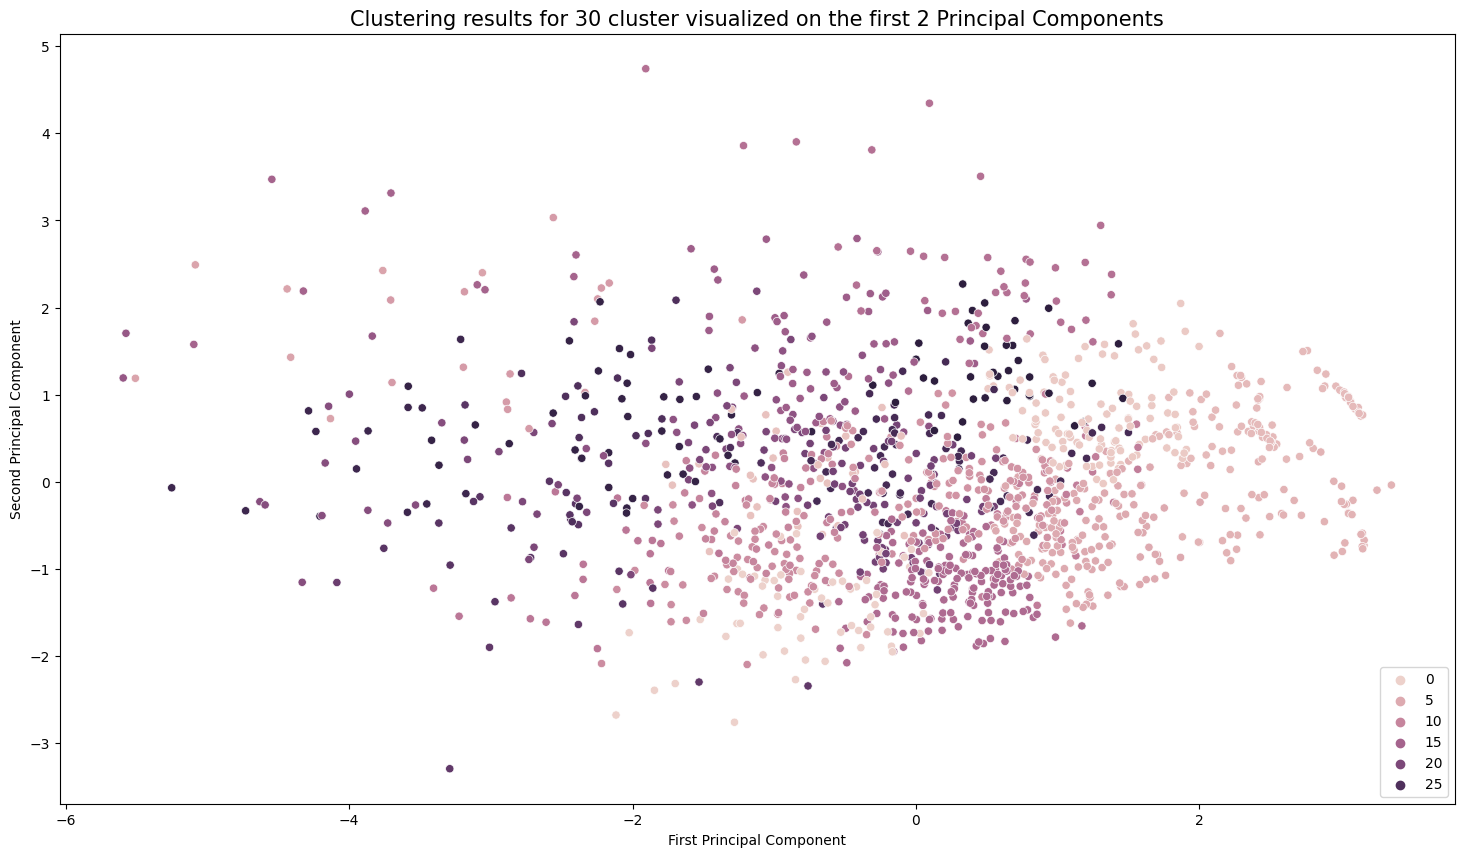

In [ ]:
plt.figure(figsize=(18,10))
sns.scatterplot(x = Y[:,0], y = Y[:,1], hue=z)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc='lower right',  bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.title('Clustering results for 30 cluster visualized on the first 2 Principal Components', fontsize=15)
plt.show()

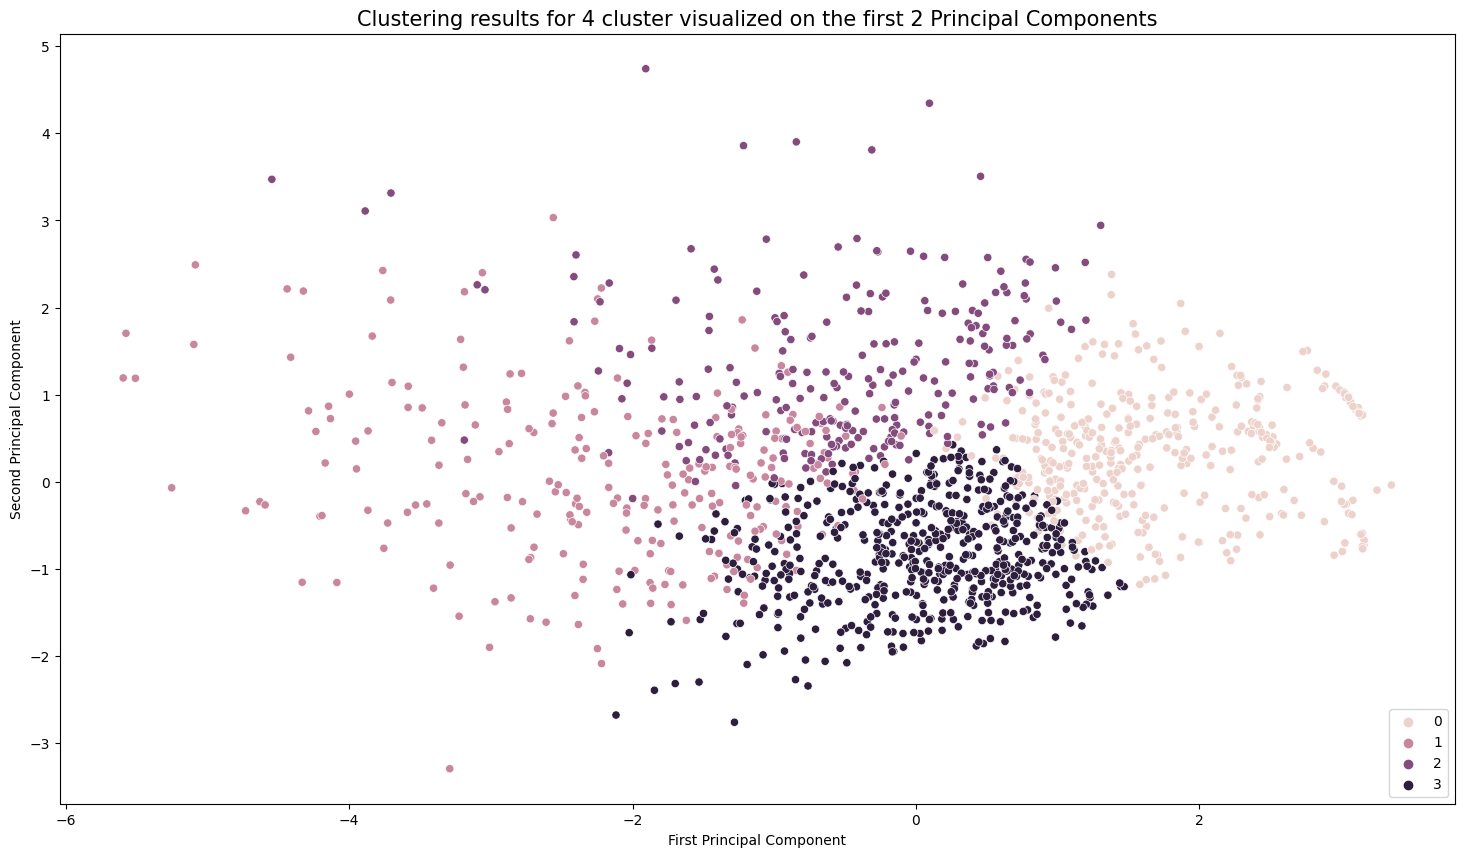

In [ ]:
obj, z, C = k_means_plusplus(data_normalized, k=4)
plt.figure(figsize=(18,10))
sns.scatterplot(x = Y[:,0], y = Y[:,1], hue=z)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc='lower right',  bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.title('Clustering results for 4 cluster visualized on the first 2 Principal Components', fontsize=15)
plt.show()

We can see the evolution in time of the four clusters 

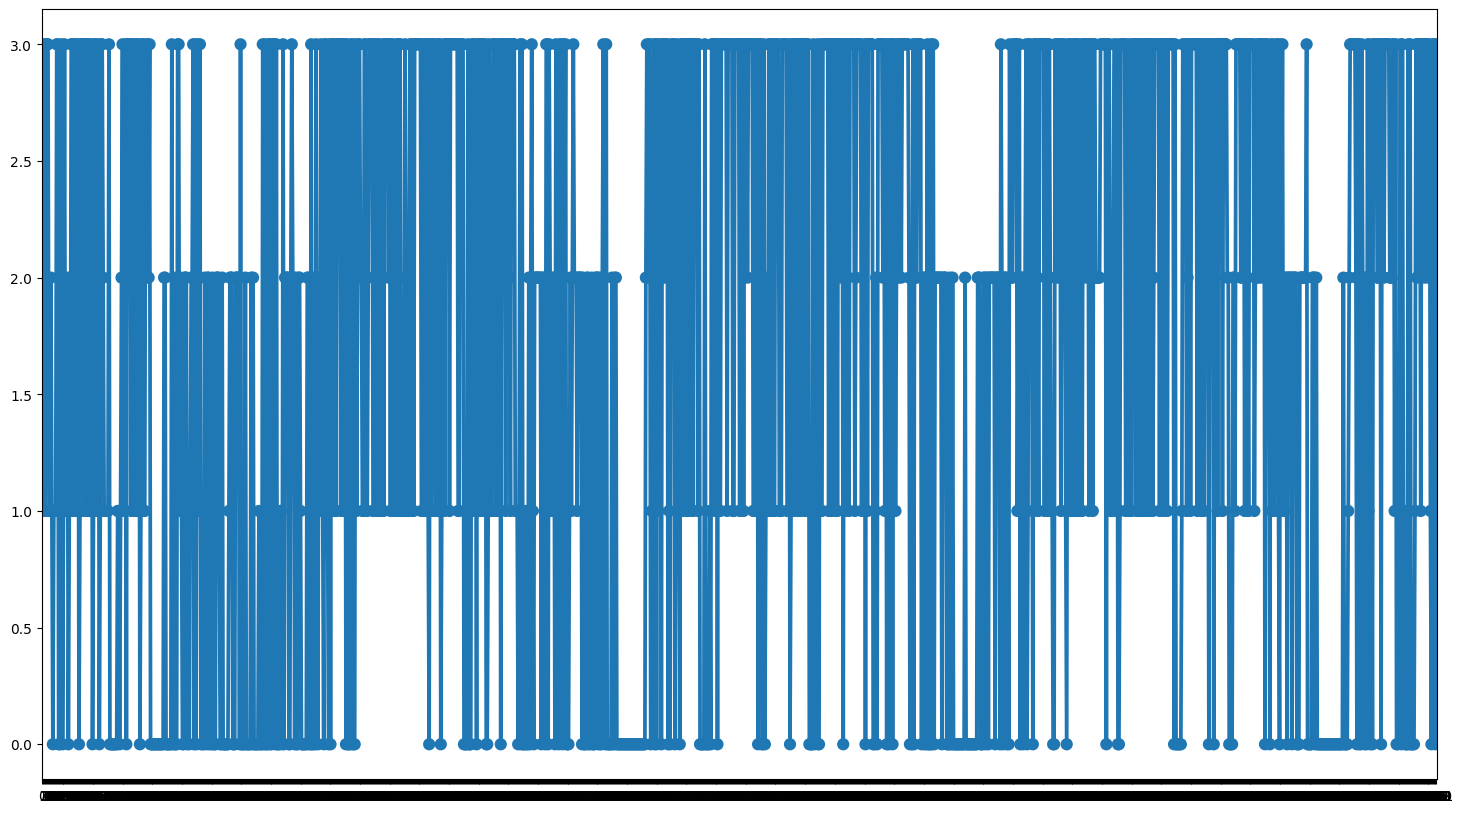

In [ ]:
plt.figure(figsize=(18,10))
sns.pointplot(x=np.arange(data_normalized.shape[0]), y=z)
plt.show()

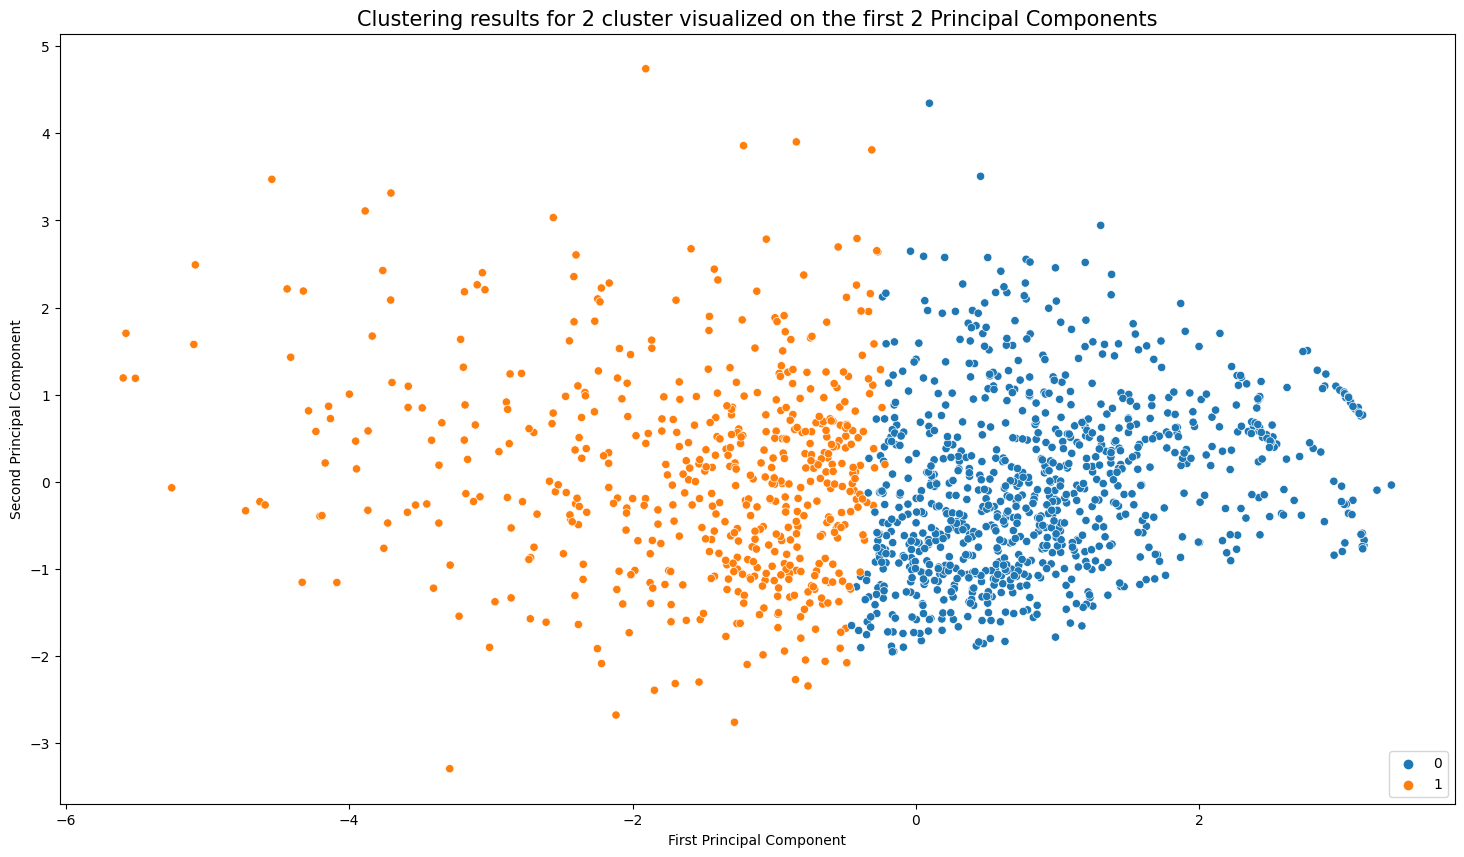

In [ ]:
obj, z, C = k_means_plusplus(data_normalized, k=2)
plt.figure(figsize=(18,10))
sns.scatterplot(x = Y[:,0], y = Y[:,1], hue=z)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc='lower right',  bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.title('Clustering results for 2 cluster visualized on the first 2 Principal Components', fontsize=15)
plt.show()

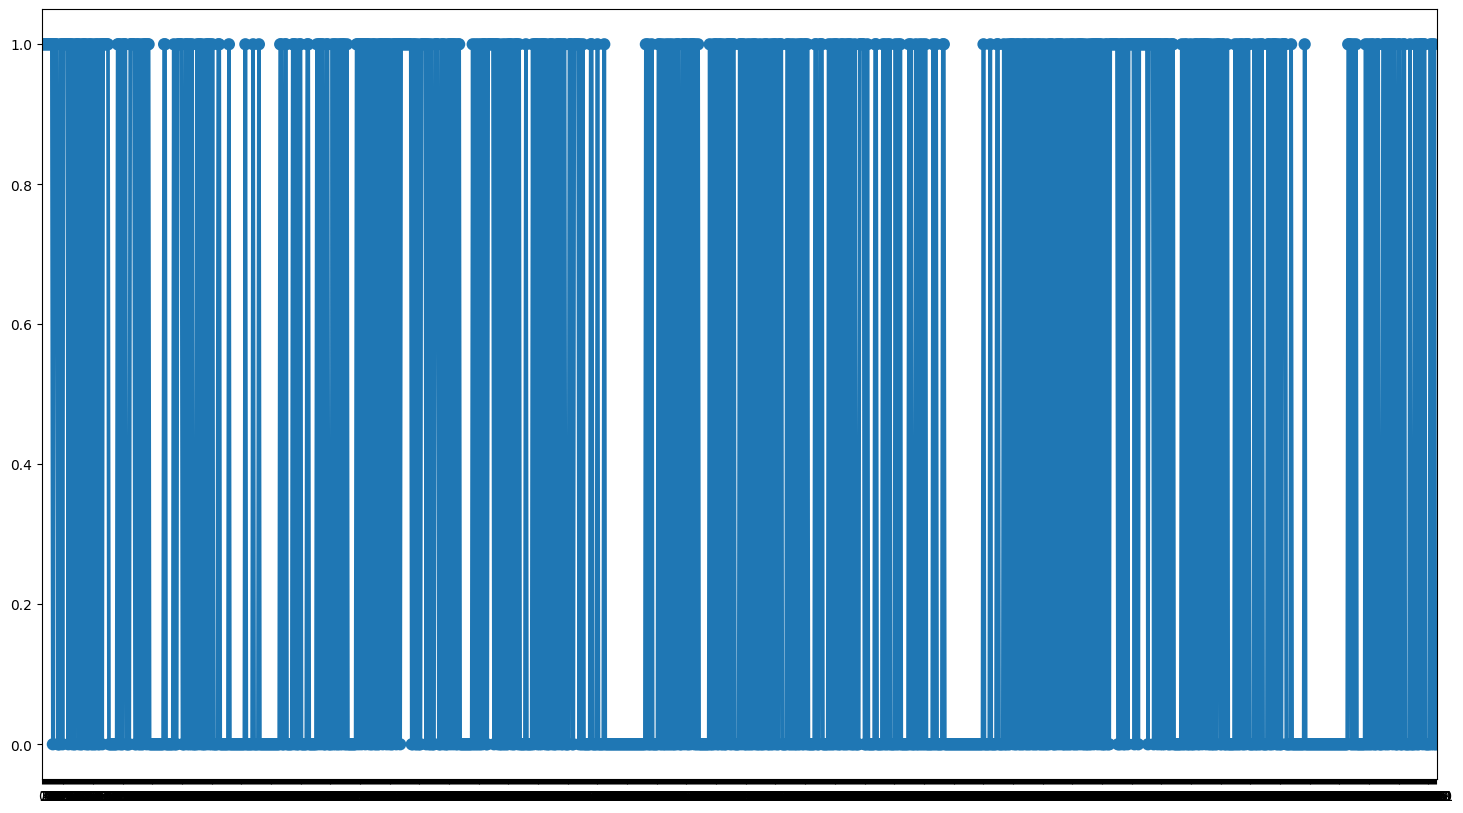

In [ ]:
plt.figure(figsize=(18,10))
sns.pointplot(x=np.arange(data_normalized.shape[0]), y=z)
plt.show()

4. Now recompute the k-means clusters, but with the goal of performing
Markov State Modeling (hint: the number of clusters necessary to perform
MSM is typically larger).

In [ ]:
objectives_MSM = []
for k in range(2, 501):
    obj, _, _ = k_means_plusplus(data_normalized, k)
    objectives_MSM.append(obj)

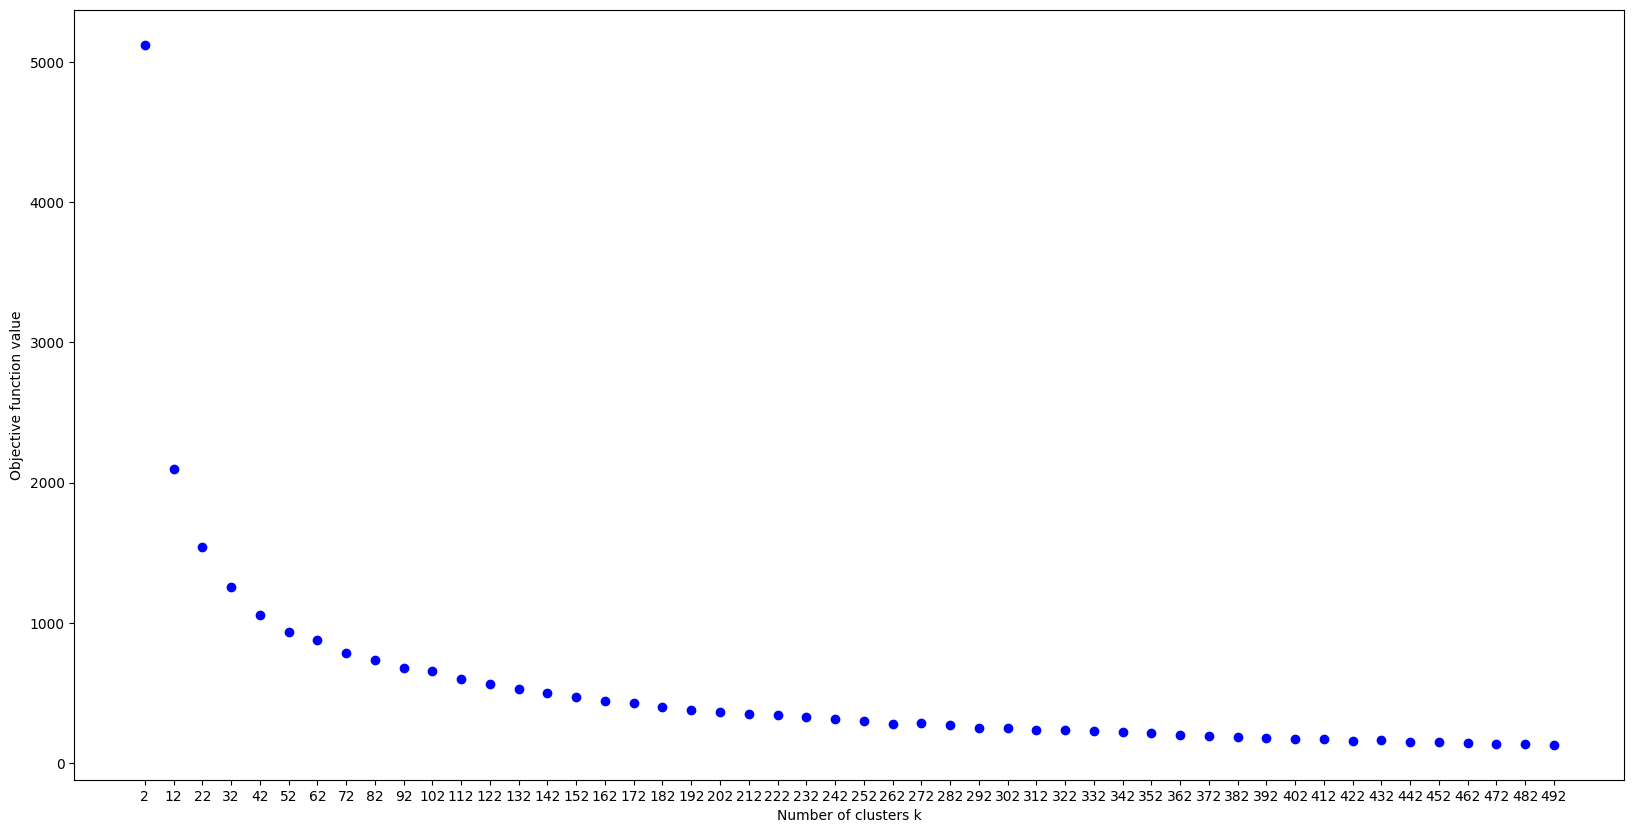

In [ ]:
scree_plot(objectives_MSM, 2, 500, 10)

`k=100` seems a reasonable choice.

In [ ]:
obj, z, C = k_means_plusplus(data_normalized, k=30)

5. Choose a time lag τ , and estimate the transition probability matrix between each pair of the clusters found in point 4. $Π_{α,β} = P(\beta,τ|\alpha,0)$


In [ ]:
def estimate_transition_matrix(z, tau):
    """ Function used to compute the markov transition matrix.

    Returns:
        P transition matrix.
    """
    num_clusters = np.max(z) + 1
    # P will have shape K x K
    P = np.zeros(shape=(num_clusters, num_clusters))

    # Fill the matrix P initially by counting the number of times
    # the system was in a certain transition
    ending_states = z[tau:]
    for (i, j) in zip(z, ending_states):
        P[i, j] += 1
    
    # Now you have to convert it to probabilites
    # So to divide P by the number of times the system was in alpha
    row_sums = P.sum(axis=1)
    P = P/row_sums[:,np.newaxis]

    return P

In [ ]:
def taus_plot(z, tau_min, tau_max):
    tau_ones = []
    tau_2 = []
    tau_3 = []
    max_tau_l = -1
    max_tau = -1
    for tau in range(tau_min, tau_max):
        P = estimate_transition_matrix(z, tau)
        evalues, _, _ = get_spectrum(P)
        tau_l = compute_relax_time(tau, evalues)
        if tau_l[0] > max_tau_l:
            max_tau_l = tau_l[0]
            max_tau = tau
        tau_ones.append(tau_l[0])
        tau_2.append(tau_l[1])
        tau_3.append(tau_l[2])
    tau_ones = np.array(tau_ones)
    plt.figure(figsize=(12,3))
    plt.plot(np.arange(tau_min, tau_max), tau_ones)
    plt.plot(np.arange(tau_min, tau_max), tau_2)
    plt.ylabel(r'$\tau_l$')
    plt.xlabel(r'$\tau$')
    plt.xticks(np.arange(0, tau_max+1, 10))
    plt.show()
    print(max_tau)

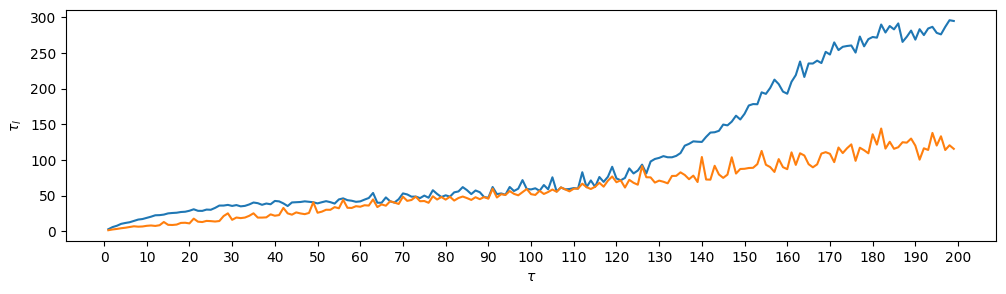

198


In [ ]:
taus_plot(z, 1, 200)

In [ ]:
tau = 190
P = estimate_transition_matrix(z, tau)

6. From the spectrum compute the relaxation times of the system. Choose
an appropriate number of Markov states. Find the Markov states by
inspecting the sign of the eigenvectors.

In [ ]:
def get_spectrum(matrix):
    """ Retain the spectrum of the transition matrix

    Returns:
        eigenvalues, left and right eigenvectors of the input matrix
    """
    # Compute eigenvalues and left and right eigenvectors of the matrix
    evalues, left_evectors, right_evectors = sp.linalg.eig(matrix, left=True, right=True)
    # Sort them in decreasing order
    sorting_indexes = np.argsort(-np.abs(evalues))
    evalues = evalues[sorting_indexes]
    left_evectors, right_evectors = left_evectors[:, sorting_indexes], right_evectors[:, sorting_indexes]

    return evalues, left_evectors, right_evectors

def compute_relax_time(tau, evalues):
    # by definition tau^gamma = -tau/log(abs(lambda^gamma))
    return -np.divide(tau, np.log(np.abs(evalues[1:])))

In [ ]:
evalues, l_evectors, r_evectors = get_spectrum(P)

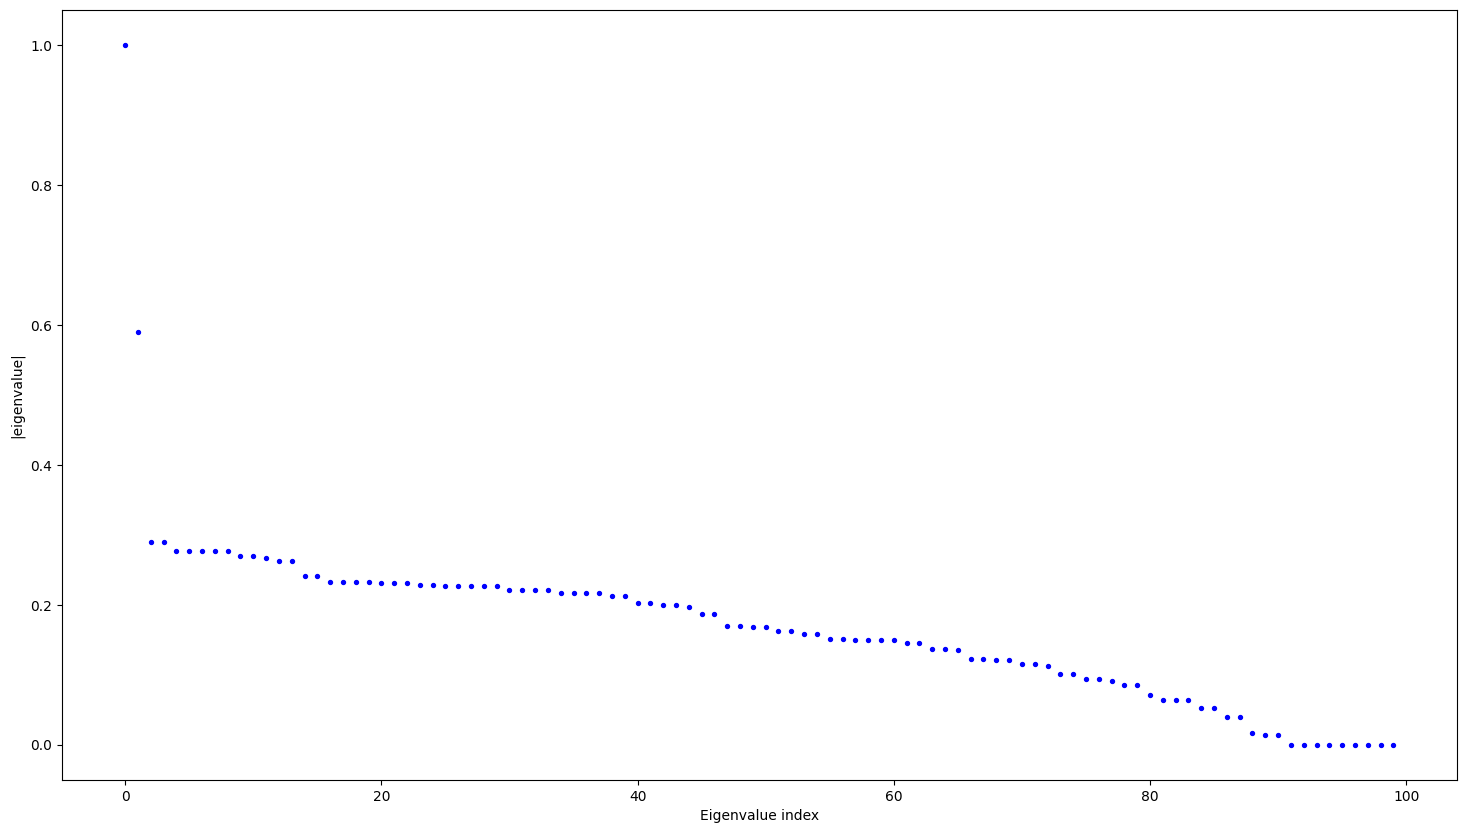

In [ ]:
# Plotting eigenvalues of the transition matrix
plt.figure(figsize=(18,10))
plt.scatter(np.arange(len(evalues)), np.abs(evalues), marker='o', color='blue', s=8)
plt.ylabel('|eigenvalue|')
plt.xlabel("Eigenvalue index")
plt.show()

In [ ]:
relax_times = compute_relax_time(tau, evalues)

<ipython-input-173-be1e9aefde33>:18: RuntimeWarning: divide by zero encountered in log
  return -np.divide(tau, np.log(np.abs(evalues[1:])))


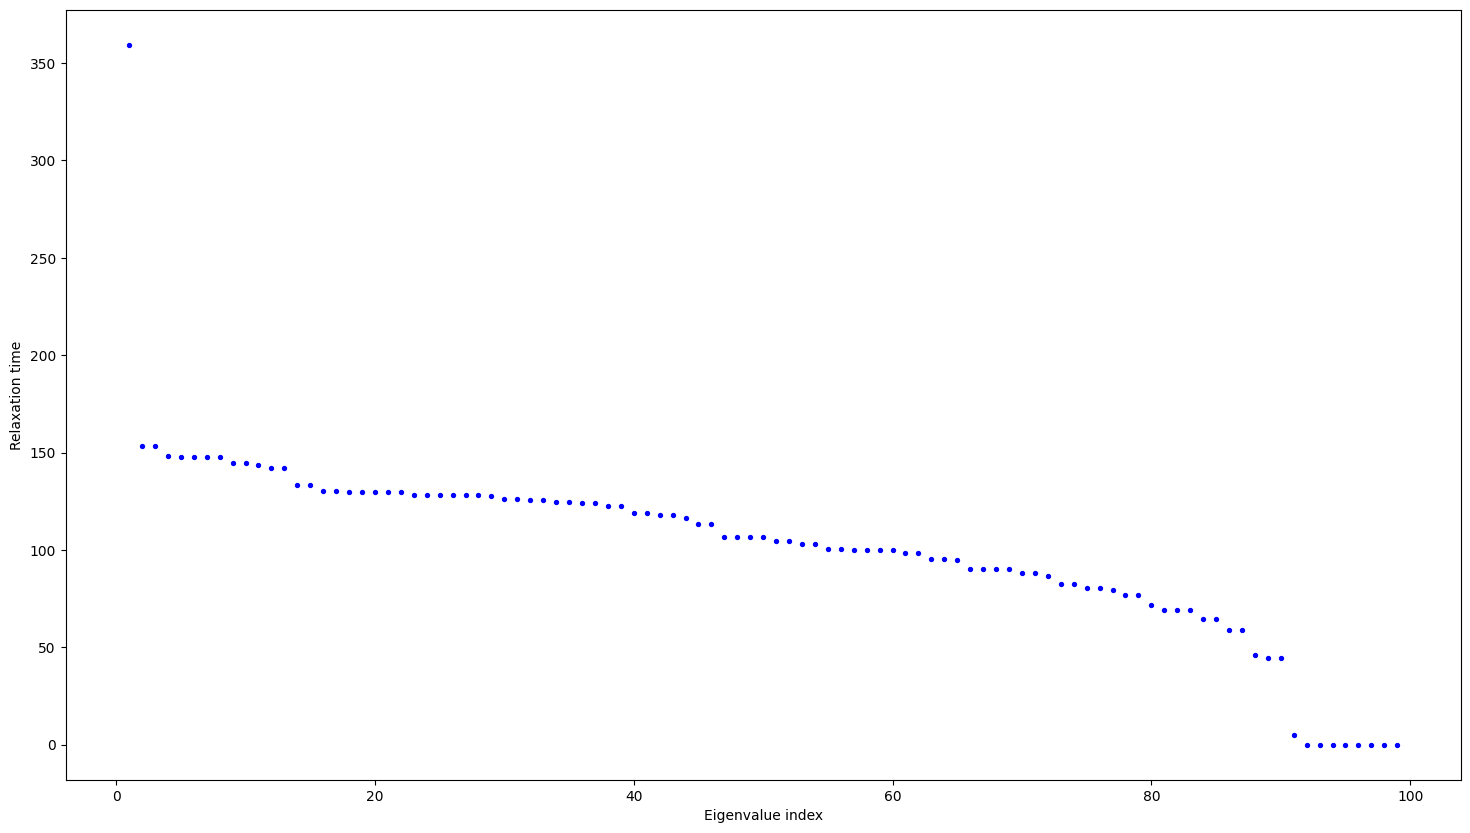

In [ ]:
# Plotting of the implicit time scales
plt.figure(figsize=(18,10))
plt.scatter(np.arange(1, len(evalues)), relax_times, marker='o', color='blue', s=8)
plt.ylabel('Relaxation time')
plt.xlabel("Eigenvalue index")
plt.show()

In [ ]:
def get_markov_states(left_eigenvectors):
    # A = np.where(np.logical_and(np.greater(left_eigenvectors[:,1],0),
    #                             np.greater(left_eigenvectors[:,2],0)))[0]

    # B = np.where(np.logical_and(np.greater(left_eigenvectors[:,1],0),
    #                             np.less(left_eigenvectors[:,2],0)))[0]

    # C = np.where(np.logical_and(np.less(left_eigenvectors[:,1],0),
    #                             np.greater(left_eigenvectors[:,2],0)))[0]

    # D = np.where(np.logical_and(np.less(left_eigenvectors[:,1],0),
    #                             np.less(left_eigenvectors[:,2],0)))[0]
    # return A, B, C, D

    A = np.where(np.greater(left_eigenvectors[:,1],0))[0]
    B = np.where(np.less(left_eigenvectors[:,1],0))[0]

    return A, B


In [ ]:
# A, B, C, D = get_markov_states(l_evectors)
A, B = get_markov_states(l_evectors)

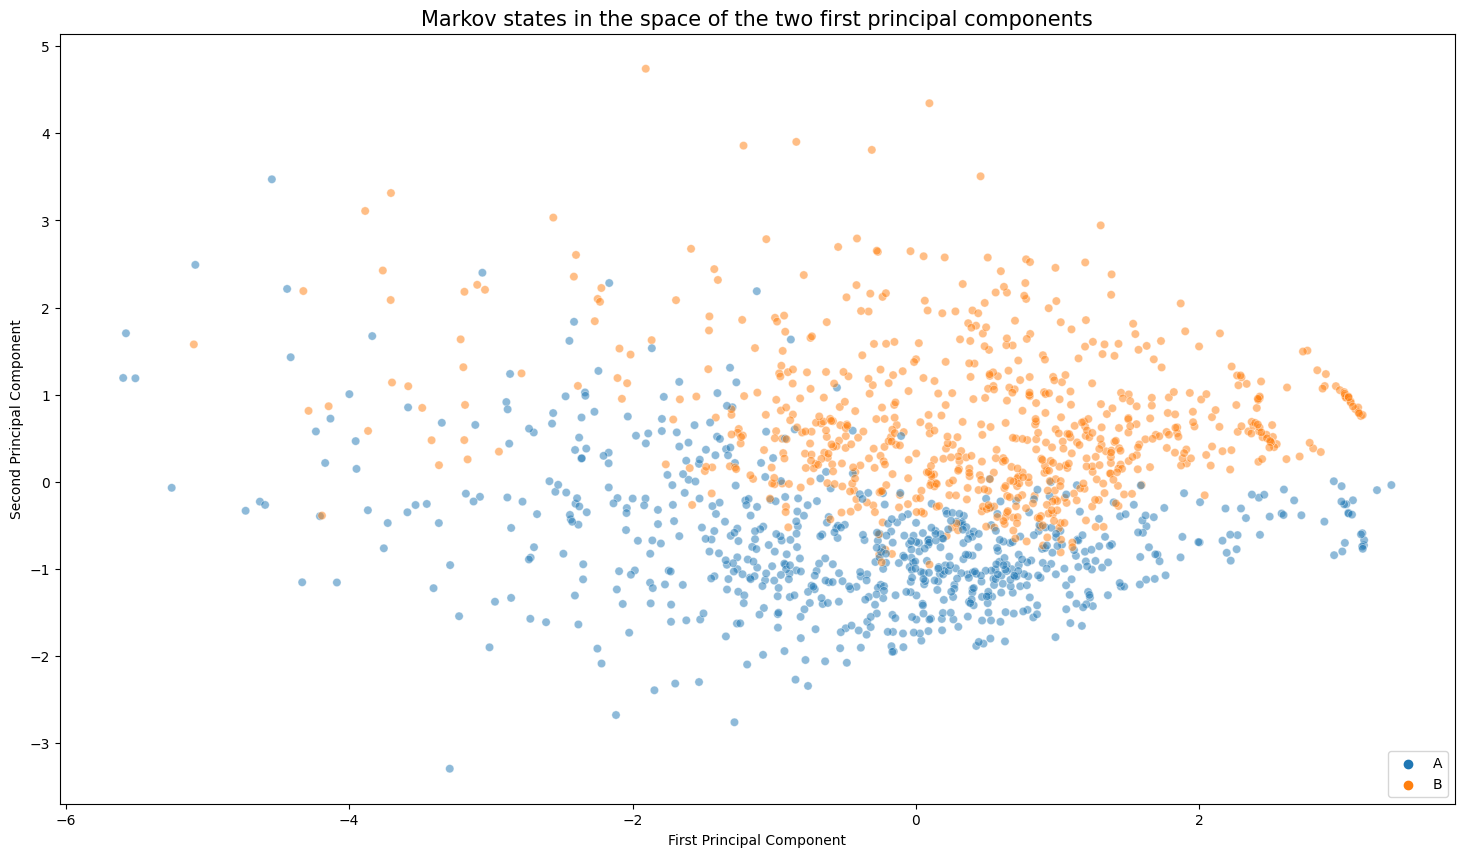

In [ ]:
labels = np.zeros(data_normalized.shape[0])
for i in B:
    labels[np.where(z==i)[0]] = 1
# for i in C:
#     labels[np.where(z==i)[0]] = 2
# for i in D:
#     labels[np.where(z==i)[0]] = 3

# mapping = {0: 'A', 1: 'B', 2: 'C', 3:'D'}
mapping = {0: 'A', 1: 'B'}
plt.figure(figsize=(18,10))
sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=pd.Series(labels).map(mapping), alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc='lower right',  bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.title('Markov states in the space of the two first principal components', fontsize=15)
plt.show()

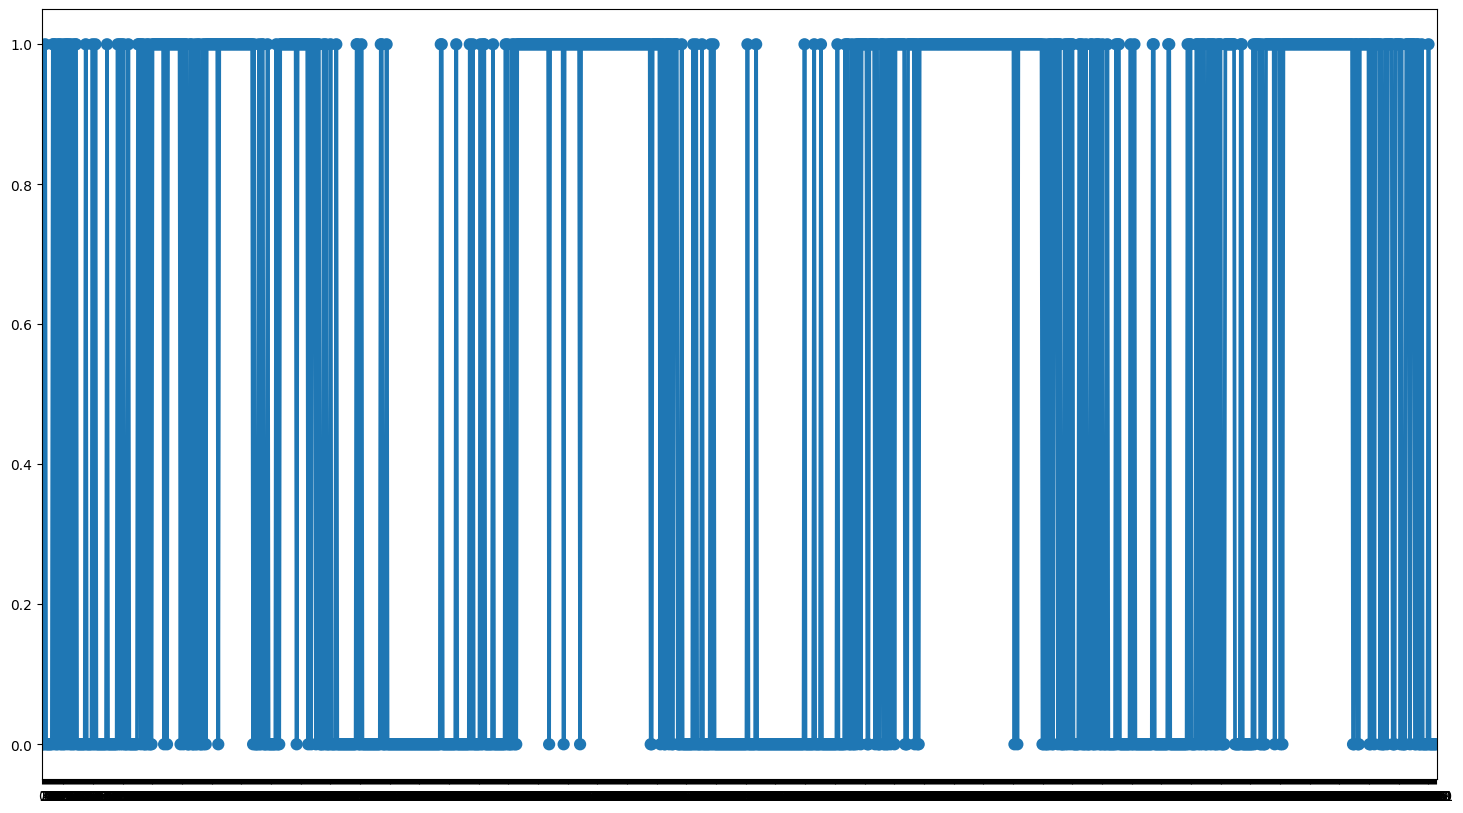

In [ ]:
plt.figure(figsize=(18,10))
sns.pointplot(x=np.arange(data_normalized.shape[0]), y=labels)
plt.show()

The clusters obtained using the Makov State Modeling technique exhibit distinct temporal behavior compared to those generated by the K-means method. Specifically, the MSM clusters effectively capture the variation in electric consumption between the hot and cold seasons. Ideally, one of the Markov states represents winter and autumn, while the other state represents spring and summer. This differentiation allows for a more accurate understanding of the seasonal differences in electric consumption patterns.